This notebook supplements the manuscript "Data-driven modeling reveals a universal dynamic underlying the COVID-19 pandemic under social distancing" by Robert Marsland III and Pankaj Mehta.

In this work, we show that the cumulative fatalities $N(t)$ for every region with more than 500 deaths as of April 15, 2020 is well-described by the function:
\begin{align}
N(t) = N_{\rm max}\Phi\left(\frac{t-t_h}{\sigma}\right),
\end{align}
where
\begin{align}
\Phi(t) &= {1 \over \sqrt{2\pi}} \int_{-\infty}^t e^{-x^2/2}\,dx
\end{align}
is the cumulative normal distribution. The same functional form provides a good fit to the cumulative number of confirmed cases for most countries with sufficient data. This model has two key parameters, the final total number of fatalities (or cases) $N_{\rm max}$, and the infection timescale $\sigma$. The third parameter $t_h$, sets the overall location of the infection curve on the time axis. 

The first cell of this notebook loads the current case and fatality data from the [Johns Hopkins github repository](https://github.com/CSSEGISandData/COVID-19) along with the best-fit values and confidence bounds for the three fitting parameters using data through April 15, 2020, and a set of functions for fitting, analyzing and simulating the data. Example code is provided for plotting the predictions, and will soon also be provided for making new predictions, and running simulations.

We emphasize that the confidence intervals shown here are <em>lower bounds</em> on the true amount of uncertainty. These intervals are calculated under the assumption that the data is accurately described by the fitting function given above, with no changes in parameter values, and with all deviations from this function due to random multiplicative noise. The confidence intervals <em>do not</em> account for possible future changes in social policy, or for systematic deviations from the fitting function that may arise at late times.

# Plot predictions

To plot the live data with the predictions made on April 15, replace the arguments of the "plot_region" function with the country and province/state of interest. Country-level data is accessed by using 'NaN' for the second argument. Dashed line marks April 15, the date the predictions were made.

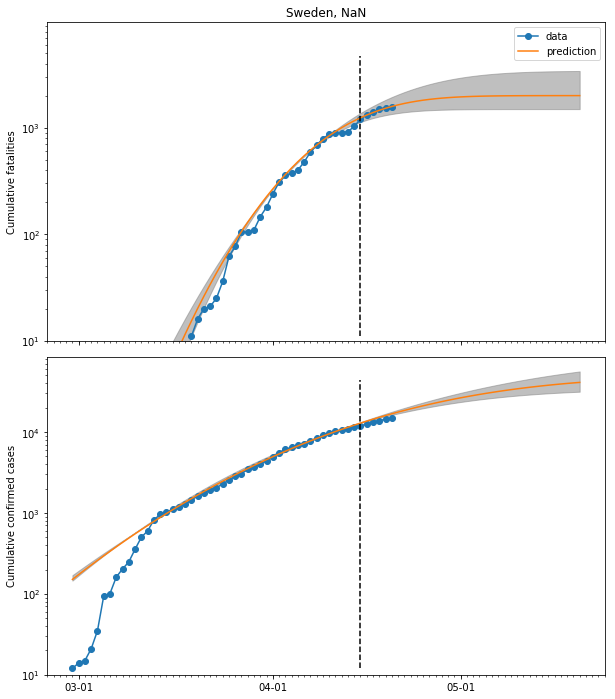

In [1]:
from covid_plotting import *
#Replace arguments with the country and province/state of interest:
plot_region('Sweden','NaN',forecast_days=30) 
#For country-level data, use 'NaN' for the second argument.
plt.show()

To access the parameters for a given region, replace the two strings in the line below with the country and state/province of interest.

For fatalities, use:

In [7]:
predictions_deaths.loc['Sweden','NaN']

Nmax                      2007.23
Nmax_low                  1499.11
Nmax_high                 3433.77
sigma                     9.88884
sigma_low                 8.60252
sigma_high                11.9405
th            2020-04-12 00:00:00
th_low        2020-04-09 00:00:00
th_high       2020-04-18 00:00:00
Name: (Sweden, NaN), dtype: object

For cases, use:

In [7]:
predictions_cases.loc['Sweden','NaN']

Nmax                      49328.6
Nmax_low                  33886.3
Nmax_high                 85215.3
sigma                     21.8862
sigma_low                 19.7903
sigma_high                24.6654
th            2020-04-29 00:00:00
th_low        2020-04-21 00:00:00
th_high       2020-05-10 00:00:00
Name: (Sweden, NaN), dtype: object

The complete spreadsheets can also be downloaded from the "output" folder of [the github repository](https://github.com/Emergent-Behaviors-in-Biology/covid19).

# Make new predictions

The cell below allows you to fit the full dataset including the latest data, for all countries and regions. It generates Pandas dataframes called `params_cases` and `params_deaths`, which contain the best-fit parameter values along with the RMS deviation of the data from the fitting function in log space ("score"). These parameters can be used as the starting point for generating confidence intervals below. The parameter `p0` sets a threshold for discarding data from the beginning of the pandemic in each region, in order to focus on the later, more universal part of the curve. All timepoints with fewer cumulative cases/fatalities than `p0` are discarded for the purposes of fitting.

In [2]:
from covid_plotting import *
params_deaths = fit_all(deaths,plot=False,p0=50)
params_cases = fit_all(cases,plot=False,p0=5e2)

The next cell computes 95 percent confidence intervals for all countries and regions, following the method described in the manuscript. As noted above, the calculation assumes that the data is accurately described by the fitting function given above, with no changes in parameter values, and with all deviations from this function due to random multiplicative noise. The best-fit parameters and upper/lower bounds on the confidence interval are contained in the Pandas dataframes `predictions_deaths` and `predictions_cases`. Set `verbose` to `False` if you do not want each countries name to be printed as its predictions are generated. <em>Note that this cell takes about 10 minutes to run.</em>

In [ ]:
predictions_deaths = predict_all(deaths,params_deaths,p0=50,verbose=True)
predictions_cases = predict_all(cases,params_cases,p0=500,verbose=True)

We can also use the best-fit parameters to perform a data collapse.

In [29]:
def plot_collapse(params_deaths,params_cases,thresh=500):
	#Extract countries with current fatalities above threshold
	thresh = 500
	current_fatalities = deaths.iloc[-1]
	current_fatalities = current_fatalities.sort_index().drop('US').loc[current_fatalities>thresh].sort_values(ascending=False)
	top_countries = current_fatalities.index
	colors = (sns.color_palette()+sns.color_palette('pastel')+sns.color_palette('dark'))*10
    
	#Fatalities rescaled
	fig,ax = data_collapse(deaths,params_deaths.loc[top_countries],endpoint=True,ms=5,colors=colors)
	#Get legend plotted correctly
	fig.set_figheight(7)
	fig.set_figwidth(12)
	ax.set_ylim((1e-3,1.5))
	ax.set_xlim((-3,3))
	ax.set_ylabel(r'Relative fatalities $N/N_{\rm max}$')
	ax.set_xlabel(r'Rescaled time $(t-t_h)/\sigma$')
	ax.set_position([0.22,0.22,0.7,0.7])
	ax.legend(loc='upper right',bbox_to_anchor=(1.25, 1))
	ax.set_title('Global Fatalities')
	plt.show()
    
	#Cases rescaled
	fig,ax = data_collapse(cases,params_cases.loc[top_countries],endpoint=True,ms=5,colors=colors)
	#Get legend plotted correctly
	fig.set_figheight(7)
	fig.set_figwidth(12)
	ax.set_ylim((1e-3,1.5))
	ax.set_xlim((-3,3))
	ax.set_ylabel(r'Relative confirmed cases $N/N_{\rm max}$')
	ax.set_xlabel(r'Rescaled time $(t-t_h)/\sigma$')
	ax.set_position([0.22,0.22,0.7,0.7])
	ax.legend(loc='upper right',bbox_to_anchor=(1.25, 1))
	ax.set_title('Global Confirmed Cases')
	plt.show()

	###########################################
	#Extract states with current fatalities above threshold
	current_fatalities = deaths['US'].iloc[-1]
	current_fatalities = current_fatalities.loc[current_fatalities>thresh].sort_index().drop('NaN').sort_values(ascending=False)
	top_countries = current_fatalities.index

	#Fatalities rescaled
	fig,ax = data_collapse(deaths['US'],params_deaths.loc['US'].loc[top_countries],endpoint=True,ms=5,colors=colors)
	#Get legend plotted correctly
	fig.set_figheight(7)
	fig.set_figwidth(12)
	ax.set_ylim((1e-3,1.5))
	ax.set_xlim((-3,3))
	ax.set_ylabel(r'Relative fatalities $N/N_{\rm max}$')
	ax.set_xlabel(r'Rescaled time $(t-t_h)/\sigma$')
	ax.set_position([0.22,0.22,0.7,0.7])
	ax.legend(loc='upper right',bbox_to_anchor=(1.25, 1))
	ax.set_title('US Fatalities')
	plt.show()
    
	#Cases rescaled
	fig,ax = data_collapse(cases['US'],params_cases.loc['US'].loc[top_countries],endpoint=True,ms=5,colors=colors)
	#Get legend plotted correctly
	fig.set_figheight(7)
	fig.set_figwidth(12)
	ax.set_ylim((1e-3,1.5))
	ax.set_xlim((-3,3))
	ax.set_ylabel(r'Relative confirmed cases $N/N_{\rm max}$')
	ax.set_xlabel(r'Rescaled time $(t-t_h)/\sigma$')
	ax.set_position([0.22,0.22,0.7,0.7])
	ax.legend(loc='upper right',bbox_to_anchor=(1.25, 1))
	ax.set_title('US Confirmed Cases')
	plt.show()

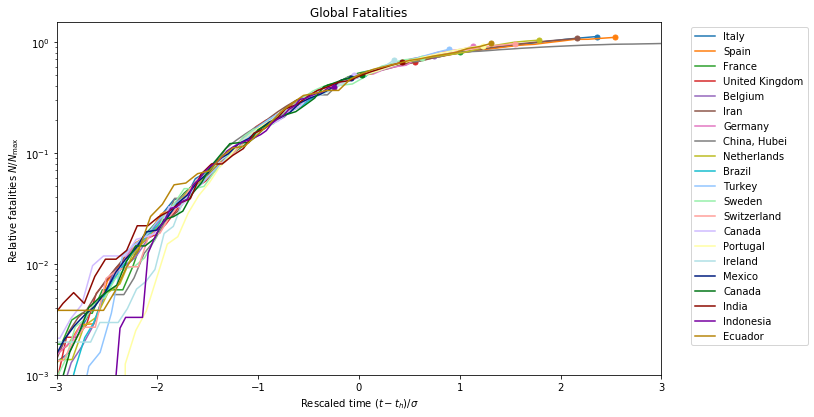

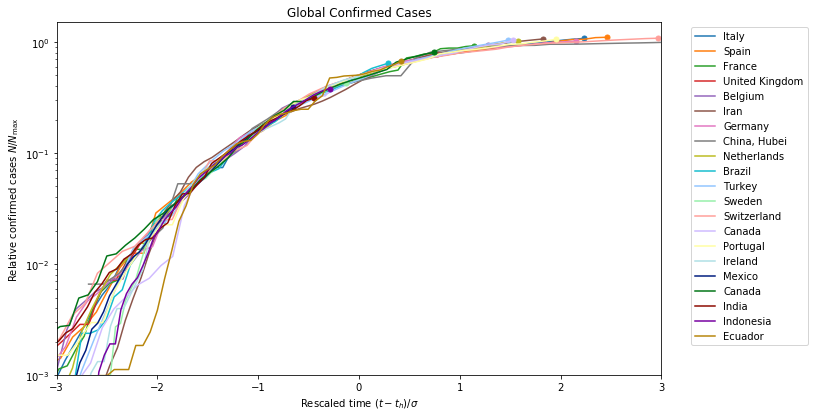

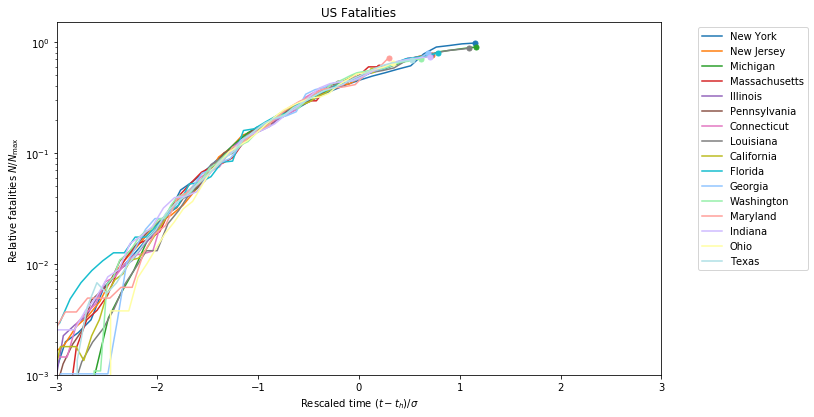

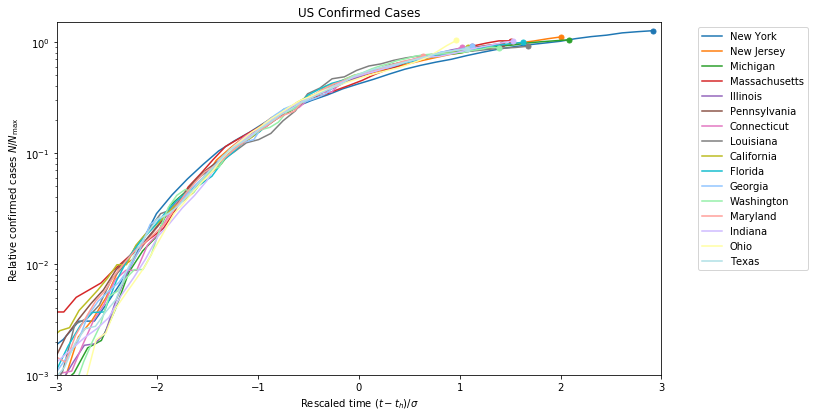

In [30]:
plot_collapse(params_deaths,params_cases)

# Run simulation

Coming soon!